In [1]:
import torch
import torch.nn as nn  
import torch.optim as optim  
from torch.distributions import Categorical

import random
import numpy as np
import time
import math

import gymnasium as gym

import imageio
from IPython.display import Image, display

from collections import deque

Environment and neural network setup

You'll begin by setting up the environment you'll use throughout the course: the Lunar Lander environment, where an agent controls the thrusters for a vehicle attempting to land on the moon.

In [2]:
# Initiate the Lunar Lander environment
env = gym.make('LunarLander-v3', render_mode="rgb_array")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v3>>>>>

In [3]:
env.action_space

Discrete(4)

In [4]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

In [5]:
# Define a neural network class that inherits from PyTorch's nn.Module base class
class Network(nn.Module):  
    
    def __init__(self, dim_inputs, dim_outputs):
        # Initialize the parent class (nn.Module) to properly set up the module
        super(Network, self).__init__()
        # Define a linear transformation (fully connected layer) with the specified input and output dimensions
        # This layer performs a linear mapping: y = xW^T + b, where W is the weight matrix and b is the bias vector
        self.linear = nn.Linear(dim_inputs, dim_outputs)

    def forward(self, x):
        # Define the forward pass of the network
        # When input `x` is passed to the network, it goes through the linear layer to produce the output
        return self.linear(x)

In [6]:
# Instantiate the network
network = Network(dim_inputs=8, dim_outputs=4)
network

Network(
  (linear): Linear(in_features=8, out_features=4, bias=True)
)

In [7]:
# Initialize the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [8]:
# dummy functions

def select_action(network, state):
    return random.randint(0, 3)

def calculate_loss(network, state, action, next_state, reward, done):
    return (network(torch.tensor(state))**2).mean()

In [9]:
n_episodes = 100
descr_every = 10

In [10]:
# Run n episodes
for episode in range(n_episodes):
    state, info = env.reset()
    done = True    
    # Run through steps until done
    while done:
        action = select_action(network, state)        
        # Take the action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated        
        loss = calculate_loss(network, state, action, next_state, reward, done)
        # print('state:', state)
        # print('loss:', loss)
        
        # Reset the gradients of all parameters in the optimizer to zero.
        # This ensures that gradients from previous iterations do not accumulate.
        optimizer.zero_grad()
        
        # Perform backpropagation to compute the gradients of the loss function 
        # with respect to the model's parameters.
        loss.backward()
        
        # Update the model's parameters using the computed gradients.
        # The optimizer adjusts the parameters to minimize the loss.
        optimizer.step()     
        
        # Update the state
        state = next_state
    if episode % descr_every == 0:
        print(f"Episode {episode} complete.")

Episode 0 complete.
Episode 10 complete.
Episode 20 complete.
Episode 30 complete.
Episode 40 complete.
Episode 50 complete.
Episode 60 complete.
Episode 70 complete.
Episode 80 complete.
Episode 90 complete.


The Q-Network architecture

You are almost ready to train your first Deep Reinforcement Learning agent! Before you can go ahead with your first complete training loop, you need a neural network architecture to drive the agent's decisions and its ability to learn.

You will modify the generic architecture you defined in an earlier exercise.

In [11]:
class QNetwork(nn.Module):
              
    def __init__(self, state_size, action_size, hidden_size, extra_layer=True):
        super(QNetwork, self).__init__()
        self.extra_layer = extra_layer
        # Instantiate the first hidden layer
        self.fc1 = nn.Linear(state_size, hidden_size)
        if self.extra_layer:
            self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Instantiate the output layer
        self.fc3 = nn.Linear(hidden_size, action_size)
    
    def forward(self, state):
        # Ensure the ReLU activation function is used
        x = torch.relu(self.fc1(torch.tensor(state)))
        if self.extra_layer:
            x = torch.relu(self.fc2(x))
        return self.fc3(x)

Instantiating the Q-Network

Now that you defined its architecture, you are ready to instantiate the actual network that your agent will be using, as well as its optimizer. 

The Gym Lunar Lander environment has a state space of dimension 8 because it represents the following key features of the lander's state:

0,1: Position (x, y): The coordinates of the lander in the 2D space.

2,3: Velocity (x, y): The linear velocities of the lander in both the x and y directions.

4: Angle: The orientation of the lander.

5: Angular Velocity: The rate at which the lander's angle is changing.

6, 7: Leg Contact (2 booleans): Two flags indicating whether each of the lander's legs is in contact with the ground.

and an action space of dimension 4, corresponding to 

0: do nothing

1: left thruster

2: main engine 

3: right thruster

In [12]:
state_size = 8
action_size = 4
hidden_size = 64
# Instantiate the Q Network
q_network = QNetwork(state_size, action_size, hidden_size)
q_network

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [13]:
# Specify the optimizer learning rate
optimizer = optim.Adam(q_network.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

Barebone DQN action selection

The select_action() function lets the agent select the action with highest Q-value at every step.

The function takes as argument the Q-network and the current state, and returns the index of the action with highest Q-value.

The Q-network is instantiated as q_network, and a random state loaded with state = torch.rand(8) to give example data to work with.

In [14]:
state = torch.rand(8)
state

tensor([0.6862, 0.7480, 0.5754, 0.3031, 0.2822, 0.8168, 0.2463, 0.1680])

In [15]:
q_network(state)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


tensor([-0.0040,  0.1635,  0.1821,  0.0661], grad_fn=<ViewBackward0>)

In [16]:
def select_action(q_network, state):
    
    # Calculate the Q-values
    q_values = q_network(state)
    # print("Q-values:", [round(x, 2) for x in q_values.tolist()])
    
    # Obtain the action index with highest Q-value
    action = torch.argmax(q_values).item()
    # print(f"Action selected: {action}, with q-value {q_values[action]:.2f}")
    
    return action

In [17]:
select_action(q_network, state)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


2

Barebone DQN loss function

The calculate_loss() returns the network loss for any given step of the episode.

In [18]:
reward = 1
gamma = .99
done = False

state = torch.rand(8)
next_state = torch.rand(8)
action = select_action(q_network, state)

state, next_state, action

C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


(tensor([0.4880, 0.5487, 0.6603, 0.3169, 0.1675, 0.7737, 0.6639, 0.2662]),
 tensor([0.9568, 0.5806, 0.9471, 0.1701, 0.3244, 0.6329, 0.3949, 0.6980]),
 2)

In [19]:
def calculate_loss(q_network, state, action, next_state, reward, done):
    q_values = q_network(state)
    # print(f'Q-values: {q_values}')
    
    # Obtain the current state Q-value
    current_state_q_value = q_values[action]
    # print(f'Current state Q-value: {current_state_q_value:.2f}')
    
    # Obtain the next state Q-value
    next_state_q_value = q_network(next_state).max()    
    # print(f'Next state Q-value: {next_state_q_value:.2f}')
    
    # Calculate the target Q-value
    target_q_value = reward + gamma * next_state_q_value * (1-done)
    # print(f'Target Q-value: {target_q_value:.2f}')
    
    # Obtain the loss
    loss = nn.MSELoss()(current_state_q_value, target_q_value)
    # print(f'Loss: {loss:.2f}')
    return loss


In [20]:
calculate_loss(q_network, state, action, next_state, reward, done)

C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


tensor(0.9966, grad_fn=<MseLossBackward0>)

Training the barebone DQN

It's time to train a Barebone DQN algorithm in the Lunar Lander environment. Keep in mind this is still a bare algorithm, so the performance won't be great, but you'll improve on it later.

In [21]:
def describe_episode(episode, reward, episode_reward, t):
    landed = reward == 100
    crashed = reward == -100
    print(
        f"| Episode {episode+1:4} | Duration: {t:4} steps | Return: {episode_reward:<7.2f} |",
        "Landed   |" if landed else "Crashed  |" if crashed else "Hovering |",
    )

In [22]:
for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    step = 0
    episode_reward = 0
    while not done:
        step += 1     
        # Select the action
        action = select_action(q_network, state)
        next_state, reward, terminated, truncated, _ = (env.step(action))
        done = terminated or truncated
        # Calculate the loss
        loss = calculate_loss(q_network, state, action, next_state, reward, done)
        optimizer.zero_grad()
        # Perform a gradient descent step
        loss.backward()
        optimizer.step()
        state = next_state
        episode_reward += reward
    if episode % descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)

| Episode    1 | Duration:  153 steps | Return: -1279.40 | Crashed  |
| Episode   11 | Duration:   88 steps | Return: -603.73 | Crashed  |
| Episode   21 | Duration:   70 steps | Return: -474.09 | Crashed  |
| Episode   31 | Duration:  111 steps | Return: -834.54 | Crashed  |
| Episode   41 | Duration:   74 steps | Return: -253.47 | Crashed  |
| Episode   51 | Duration:   61 steps | Return: -126.33 | Crashed  |
| Episode   61 | Duration:   77 steps | Return: -460.20 | Crashed  |
| Episode   71 | Duration:   58 steps | Return: -102.06 | Crashed  |
| Episode   81 | Duration:   88 steps | Return: 23.40   | Crashed  |
| Episode   91 | Duration:  118 steps | Return: -287.23 | Crashed  |


In [23]:
# Executing and Rendering the environment fter training the neural network

def exec_rend(network, fps, PN=False):
    state, info = env.reset()
    done = False
    episode_reward = 0
    frames = []
    steps = 0
    
    while not done:
        frame = env.render()  # Render the environment
        frames.append(frame)
    
        # Use the trained network to select the action
        if PN==True:
            action, _ = select_action_policy(network, state)  
        else:
            action = select_action(network, state)
    
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    
        state = next_state
        episode_reward += reward
        steps+=1
    
    env.close()  # Close the rendering window
    
    fps = fps
    gif_path = "lunar_lander.gif"
    
    # Save frames as a GIF
    imageio.mimsave(gif_path, frames, fps=fps)
    
    # Calculate the total duration of the GIF in seconds
    gif_duration = math.ceil(steps / fps)

    # Display the GIF
    display(Image(filename=gif_path))
    
    # Wait until the GIF finishes
    time.sleep(gif_duration)
    
    # Print a message after the GIF finishes
    print("The episode has completed in", gif_duration, 'seconds')
    
    describe_episode(0, reward, episode_reward, steps)

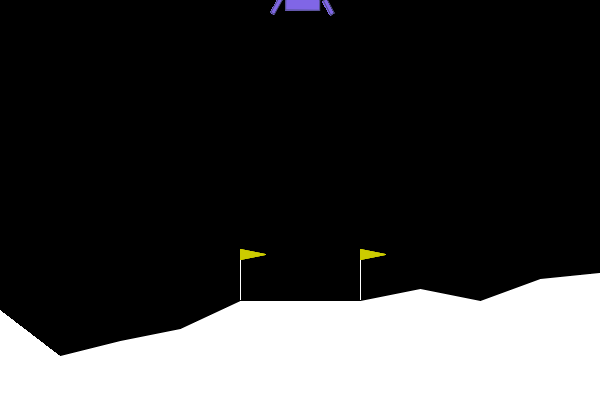

The episode has completed in 10 seconds
| Episode    1 | Duration:   99 steps | Return: -198.32 | Crashed  |


In [24]:
exec_rend(network=q_network, fps=10)

The double-ended queue

Familiarize yourself the with Double-Ended Queue data structure which you will use as replay buffer.

The Double Ended Queue, or deque is a limited capacity queue which 'forgets' its oldest items as new items are added over time. This provides a well suited abstraction to support the replay buffer.

This is similar to what you will do next with Experience Replay, sampling a batch of experiences at each step -- with a deque serving as memory buffer.

In [25]:
buffer = deque(range(10))
print('Buffer initialized as:', buffer)

Buffer initialized as: deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [26]:
# Append 10 to the right of the buffer
buffer.append(10)
print('Buffer after appending:', buffer)

Buffer after appending: deque([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


In [27]:
# Set a maximum capacity of 5
buffer = deque(range(10), maxlen=5)
print('Buffer initialized as:', buffer)

Buffer initialized as: deque([5, 6, 7, 8, 9], maxlen=5)


In [28]:
buffer.append(10)
print('Buffer after appending:', buffer)

Buffer after appending: deque([6, 7, 8, 9, 10], maxlen=5)


In [29]:
buffer = deque(range(10), maxlen=5)
print('Buffer initialized as:', buffer)

Buffer initialized as: deque([5, 6, 7, 8, 9], maxlen=5)


In [30]:
# Draw three items from the buffer
batch = random.sample(buffer, 3)
print('Random sample from buffer:', batch)

Random sample from buffer: [5, 6, 8]


Experience replay buffer

You will now create the data structure to support Experience Replay, which will enable your agent to learn much more efficiently.

This replay buffer should support two operations:

Storing experiences in its memory for future sampling.
"Replaying" a randomly sampled batch of past experiences from its memory.

As the data sampled from the replay buffer will be used to feed into a neural network, the buffer should return torch Tensors for convenience.

In [31]:
class ReplayBuffer:
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        experience_tuple = (state, action, reward, next_state, done)
        # Append experience_tuple to the memory buffer
        self.memory.append(experience_tuple)    
        
    def __len__(self):
        return len(self.memory)
        
    def sample(self, batch_size):
        # Draw a random sample of size batch_size
        batch = random.sample(self.memory, batch_size)
        # print('batch:', batch)
        # print('zip(*batch):', zip(*batch))
        # Transform batch into a tuple of lists
        states, actions, rewards, next_states, dones = zip(*batch)
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)
        # Ensure actions_tensor has shape (batch_size, 1)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

In [32]:
# Create a ReplayBuffer object with a capacity of 10
buffer = ReplayBuffer(capacity=10)
buffer

In [33]:
# Populate the buffer with dummy experiences
for i in range(15):  # Adding more than the capacity to test maxlen behavior
    
    state = [i, i + 1, i + 2]  # Dummy state
    action = i  # Dummy action
    reward = i * 0.1  # Dummy reward
    next_state = [i + 3, i + 4, i + 5]  # Dummy next state
    done = i % 2 == 0  # Dummy done flag
    
    buffer.push(state, action, reward, next_state, done)
    print(f"Added experience {i}: Buffer size = {len(buffer)}")

Added experience 0: Buffer size = 1
Added experience 1: Buffer size = 2
Added experience 2: Buffer size = 3
Added experience 3: Buffer size = 4
Added experience 4: Buffer size = 5
Added experience 5: Buffer size = 6
Added experience 6: Buffer size = 7
Added experience 7: Buffer size = 8
Added experience 8: Buffer size = 9
Added experience 9: Buffer size = 10
Added experience 10: Buffer size = 10
Added experience 11: Buffer size = 10
Added experience 12: Buffer size = 10
Added experience 13: Buffer size = 10
Added experience 14: Buffer size = 10


In [34]:
# Check the memory contents
print("\nCurrent ReplayBuffer contents:")
for exp in buffer.memory:
    print(exp)


Current ReplayBuffer contents:
([5, 6, 7], 5, 0.5, [8, 9, 10], False)
([6, 7, 8], 6, 0.6000000000000001, [9, 10, 11], True)
([7, 8, 9], 7, 0.7000000000000001, [10, 11, 12], False)
([8, 9, 10], 8, 0.8, [11, 12, 13], True)
([9, 10, 11], 9, 0.9, [12, 13, 14], False)
([10, 11, 12], 10, 1.0, [13, 14, 15], True)
([11, 12, 13], 11, 1.1, [14, 15, 16], False)
([12, 13, 14], 12, 1.2000000000000002, [15, 16, 17], True)
([13, 14, 15], 13, 1.3, [16, 17, 18], False)
([14, 15, 16], 14, 1.4000000000000001, [17, 18, 19], True)


In [35]:
# Sample a batch of experiences
batch_size = 5
print(f"\nSampling a batch of size {batch_size}:")
states, actions, rewards, next_states, dones = buffer.sample(batch_size)

# Display sampled tensors
print("States:", states)
print("Actions:", actions)
print("Rewards:", rewards)
print("Next States:", next_states)
print("Dones:", dones)


Sampling a batch of size 5:
States: tensor([[13., 14., 15.],
        [ 6.,  7.,  8.],
        [ 8.,  9., 10.],
        [ 7.,  8.,  9.],
        [14., 15., 16.]])
Actions: tensor([[13],
        [ 6],
        [ 8],
        [ 7],
        [14]])
Rewards: tensor([1.3000, 0.6000, 0.8000, 0.7000, 1.4000])
Next States: tensor([[16., 17., 18.],
        [ 9., 10., 11.],
        [11., 12., 13.],
        [10., 11., 12.],
        [17., 18., 19.]])
Dones: tensor([0., 1., 1., 0., 1.])


DQN with experience replay

You will now introduce Experience Replay to train an agent using a Deep Q Network. You will use the same Lunar Lander environment as you did to build your Barebone DQN.

At every step, instead of using only the learnings from the most recent transition to update the network, the Experience Replay buffer enables the agent to learn from a random batch of recent experiences. This considerably improves its ability to learn about the environment.

In [36]:
replay_buffer = ReplayBuffer(capacity=10000)
batch_size = 64

In [37]:
# gather is a method provided by PyTorch for torch.Tensor objects.

q_values = torch.tensor([[1.0, 2.0, 3.0], 
                         [4.0, 5.0, 6.0], 
                         [7.0, 8.0, 9.0]])  # Shape: (3, 3)

actions = torch.tensor([[1], [0], [2]])  # Shape: (3, 1)

selected_q_values = q_values.gather(1, actions)  # Shape: (3, 1)
print('selected_q_values:', selected_q_values)

final_q_values = selected_q_values.squeeze(1)  # Shape: (3,)
print('final_q_values:', final_q_values)

selected_q_values: tensor([[2.],
        [4.],
        [9.]])
final_q_values: tensor([2., 4., 9.])


In [38]:
# In the code provided, the experience replay is implemented by storing experiences in the ReplayBuffer 
# and sampling batches of experiences once the buffer has enough data (if len(replay_buffer) >= batch_size:). 
# The replay ensures that the model learns from a diverse set of past experiences, 
# which should improve training stability and efficiency compared to using only the most recent experiences.


for episode in range(n_episodes):
    # Reset the environment at the start of each episode
    state, info = env.reset()
    
    done = False  # Boolean flag to indicate whether the episode is finished
    step = 0  # Counter to keep track of the number of steps in the episode
    episode_reward = 0  # Variable to accumulate the total reward for this episode

    # While the episode is not yet completed (neither terminated nor truncated)
    while not done:
        step += 1
        
        # Use the Q-network to predict Q-values for the current state
        # Q-values represent the expected reward for each possible action in this state
        q_values = q_network(state)
        
        # Select the action with the highest Q-value (greedy action selection)
        # torch.argmax returns the index of the maximum Q-value, which corresponds to the action
        action = torch.argmax(q_values).item()

        # Perform the selected action in the environment
        # Returns the next state, reward, termination flag, truncation flag, and additional info
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Update the done flag to indicate the end of the episode
        # An episode ends either if terminated (goal reached or failure) or truncated (time limit exceeded)
        done = terminated or truncated
        
        # Store the current experience in the replay buffer
        # The experience is represented as a tuple: (state, action, reward, next_state, done)
        replay_buffer.push(state, action, reward, next_state, done)

        # If the replay buffer has enough experiences (equal or greater to batch size)
        if len(replay_buffer) >= batch_size:
            # Sample a batch of experiences from the replay buffer
            # This method returns tensors for states, actions, rewards, next_states, and done flags
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Predict Q-values for the sampled states using the Q-network
            # Gather the Q-values corresponding to the sampled actions
            # The .gather(1, actions) method selects the Q-values for the specific actions taken
            q_values = q_network(states).gather(1, actions).squeeze(1)

            # Predict Q-values for the sampled next states using the Q-network
            # .amax(dim=1) computes the maximum Q-value across all possible actions
            next_state_q_values = q_network(next_states).amax(dim=1)
            
            # Compute the target Q-values for training
            # The target is the immediate reward plus the discounted maximum Q-value of the next state
            # (1 - dones) ensures that the target Q-value is zero for terminal states
            target_q_values = rewards + gamma * next_state_q_values * (1 - dones)
            
            # Calculate the loss between the predicted Q-values and target Q-values
            # Mean Squared Error (MSE) loss is commonly used for Q-learning
            loss = nn.MSELoss()(target_q_values, q_values)
            
            # Zero the gradients to prepare for backpropagation
            optimizer.zero_grad()
            
            # Perform backpropagation to compute gradients
            loss.backward()
            
            # Update the Q-network's parameters using the computed gradients
            optimizer.step()

        # Update the current state to the next state for the next iteration
        state = next_state

        # Accumulate the reward received in this step to the episode's total reward
        episode_reward += reward

    # Once the episode is finished, log its details for analysis
    # describe_episode is assumed to be a function that outputs information about the episode
    if episode%descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)


C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\3868540135.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states_tensor = torch.tensor(states, dtype=torch.float32)
C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


| Episode    1 | Duration:  137 steps | Return: -399.46 | Crashed  |
| Episode   11 | Duration:   72 steps | Return: -517.10 | Crashed  |
| Episode   21 | Duration:   58 steps | Return: -176.68 | Crashed  |
| Episode   31 | Duration:   79 steps | Return: -163.73 | Crashed  |
| Episode   41 | Duration:   52 steps | Return: -102.20 | Crashed  |
| Episode   51 | Duration:  108 steps | Return: -12.67  | Crashed  |
| Episode   61 | Duration:  246 steps | Return: 238.66  | Landed   |
| Episode   71 | Duration:  714 steps | Return: -238.20 | Crashed  |
| Episode   81 | Duration: 1000 steps | Return: -200.75 | Hovering |
| Episode   91 | Duration:  242 steps | Return: -322.36 | Crashed  |


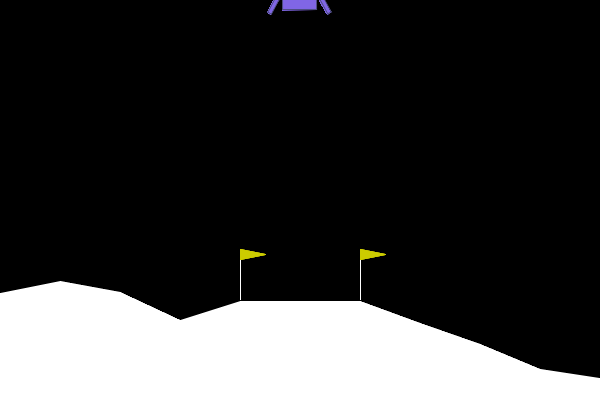

The episode has completed in 15 seconds
| Episode    1 | Duration:  144 steps | Return: -40.83  | Crashed  |


In [39]:
exec_rend(network=q_network, fps=10)

Epsilon-greediness

In this exercise, you will implement a select_action_greedy() function that applies decayed epsilon-greediness.

Epsilon-greediness will encourage your agent to explore the environment, which should improve learning!

The epsilon-greediness schedule determines a threshold for any given step, as given by the formula:

epsilon = end + (start - end) * e^(-step/decay)

select_action_greedy() should return a random action with probability epsilon, and the action with highest Q-value with probability (1 - epsilon).

In [40]:
# Define a function to select an action based on epsilon-greedy strategy
def select_action_greedy(q_values, step, start, end, decay):
    """
    Select an action using epsilon-greedy strategy.

    Parameters:
    - q_values: Tensor containing the Q-values for all possible actions.
    - step: Current training step (used for epsilon decay).
    - start: Initial value of epsilon.
    - end: Final value of epsilon after sufficient decay.
    - decay: The decay rate to control how quickly epsilon approaches its final value.

    Returns:
    - An action index (either random or the one with highest Q-value).
    """
    
    # Calculate the epsilon (exploration probability) for the current step
    # Epsilon decreases exponentially with the number of steps to encourage more exploitation over time
    epsilon = end + (start - end) * math.exp(-step / decay)
    
    # Generate a random number between 0 and 1 to decide whether to explore or exploit
    sample = random.random()
    
    # If the random sample is less than epsilon, choose a random action (exploration)
    if sample < epsilon:
        return random.choice(range(len(q_values)))  # Randomly select one of the available action indices
    
    # Otherwise, choose the action with the highest Q-value (exploitation)
    return torch.argmax(q_values).item()


In [41]:
# Test the select_action_greedy function at different training steps
for step in [1, 500, 2500]:  # Steps at which to evaluate the behavior of epsilon decay
    # Select 20 actions for a fixed Q-value tensor [1, 2, 3, 5]
    actions = [select_action_greedy(torch.Tensor([1, 2, 3, 5]), step, 0.9, 0.05, 1000) for _ in range(20)]
    
    # Print the selected actions for each step
    print(f"Selecting 20 actions at step {step}.\n"
          f"The action with the highest Q-value is action 3.\n"
          f"Selected actions: {actions}\n\n")

Selecting 20 actions at step 1.
The action with the highest Q-value is action 3.
Selected actions: [3, 3, 0, 3, 3, 3, 3, 1, 0, 2, 3, 0, 3, 2, 1, 1, 3, 2, 1, 3]


Selecting 20 actions at step 500.
The action with the highest Q-value is action 3.
Selected actions: [0, 2, 3, 3, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 2, 0, 3, 3]


Selecting 20 actions at step 2500.
The action with the highest Q-value is action 3.
Selected actions: [3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]




Fixed Q-targets

You are preparing to train your Lunar Lander with fixed Q-targets. As a prerequisite, you need to instantiate both the online network (which chooses the action) and the target network (used for TD-target calculation).

You also need to implement an update_target_network function which you can use at each training step. The target network is not updated by gradient descent; instead, update_target_network nudges its weights towards the Q-network by a small amount, ensuring that it remains quite stable over time.

Note that, for this exercise only, you use a very small network so we can easily print and inspect its state dictionary. It has only one hidden layer of size two; its action space and state space are also of dimension 2.

In [42]:
# Create instances of the simple Network

state_dim = 2  # Dimension of the state space
action_dim = 2  # Dimension of the action space
hidden_dim = 2 # Dimension of the hidden layer

In [43]:
online_network = QNetwork(state_dim, action_dim, hidden_dim, extra_layer=False)
online_network.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.5732,  0.4820],
                      [-0.3995,  0.4144]])),
             ('fc1.bias', tensor([-0.5676,  0.2575])),
             ('fc3.weight',
              tensor([[ 0.3345, -0.5307],
                      [ 0.4935,  0.4286]])),
             ('fc3.bias', tensor([0.0429, 0.6460]))])

In [44]:
target_network = QNetwork(state_dim, action_dim, hidden_dim, extra_layer=False)
target_network.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.1335, -0.0393],
                      [ 0.3107, -0.0850]])),
             ('fc1.bias', tensor([ 0.1539, -0.6359])),
             ('fc3.weight',
              tensor([[ 0.6067, -0.5696],
                      [ 0.1393, -0.4606]])),
             ('fc3.bias', tensor([-0.6426,  0.2622]))])

In [45]:
def update_target_network(target_network, online_network, tau):
    """
    Updates the target network's weights as a soft update of the online network's weights.
    This is commonly used in deep reinforcement learning to stabilize training.

    Parameters:
    - target_network: The network that is being slowly updated (target network).
    - online_network: The network that is being actively trained (online network).
    - tau: The update factor (a value between 0 and 1) that controls the speed of the update.

    Returns:
    - None
    """
    
    # Obtain the state dictionaries (weight and bias parameters) of both networks
    # The state_dict is a dictionary mapping parameter names to their tensor values
    target_net_state_dict = target_network.state_dict()
    online_net_state_dict = online_network.state_dict()

    # Iterate through each parameter in the online network's state dictionary
    for key in online_net_state_dict:
        # Perform a weighted update of the target network's parameter using tau
        # This is a "soft update" formula:
        # target_param = tau * online_param + (1 - tau) * target_param
        target_net_state_dict[key] = (
            online_net_state_dict[key] * tau +  # Weighted contribution from the online network
            target_net_state_dict[key] * (1 - tau)  # Weighted contribution from the target network
        )
    
    # Load the updated parameters (state_dict) back into the target network
    # This applies the calculated updates to the target network
    target_network.load_state_dict(target_net_state_dict)
    
    # Return None explicitly (optional, since the function doesn't return a value)
    return None


In [46]:
update_target_network(target_network, online_network, .001)
target_network.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.1340, -0.0388],
                      [ 0.3100, -0.0845]])),
             ('fc1.bias', tensor([ 0.1532, -0.6350])),
             ('fc3.weight',
              tensor([[ 0.6064, -0.5696],
                      [ 0.1397, -0.4597]])),
             ('fc3.bias', tensor([-0.6420,  0.2626]))])

Implementing the complete DQN algorithm

The time has finally arrived! All the prerequisites are complete; you will now implement the full DQN algorithm and use it to train a Lunar Lander agent. This means that your algorithm will use not just Experience Replay, but also Decayed Epsilon-Greediness and Fixed Q-Targets.

The select_action_greedy() function implementing Decayed Epsilon Greediness is available for you to use, as is the update_target_network() function from the last exercise. All that remains to do is fit those functions in the DQN training loop, and ensure that you are correctly using the Target Network in the loss caculations.

You need to keep a new step counter, total_steps, to decay the value for epsilon over time. This variable is initialized with value 0.

In [47]:
# Create instances of the regular Network

state_dim = 8  # Dimension of the state space
action_dim = 4  # Dimension of the action space
hidden_dim = 64 # Dimension of the hidden layer

In [48]:
online_network = QNetwork(state_dim, action_dim, hidden_dim)
online_network

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [49]:
optimizer = optim.Adam(online_network.parameters(), lr=0.0001)

In [50]:
target_network = QNetwork(state_dim, action_dim, hidden_dim)
target_network

QNetwork(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [51]:
total_steps = 0
batch_size = 64
replay_buffer = ReplayBuffer(capacity=10000)

In [52]:
# Loop over n episodes to train the agent
for episode in range(n_episodes):
    # Reset the environment to start a new episode
    # Returns the initial state and additional information
    state, info = env.reset()
    
    # Initialize variables to track episode progress
    done = False  # Flag to check if the episode has ended
    step = 0  # Step counter for the current episode
    episode_reward = 0  # Tracks the total reward obtained in this episode

    # Continue looping until the episode is finished
    while not done:
        # Increment the step counter for this episode
        step += 1
        
        # Increment the global step counter (used for tracking training progress)
        total_steps += 1

        # Use the online network to predict Q-values for the current state
        # Q-values represent the expected rewards for each possible action
        q_values = online_network(state)
        
        # Select an action using an epsilon-greedy strategy
        # This allows for a balance between exploration (random actions) and exploitation (choosing the best action)
        action = select_action_greedy(q_values, total_steps, start=0.9, end=0.05, decay=1000)
        
        # Perform the chosen action in the environment
        # Returns the next state, reward, termination flag, truncation flag, and additional info
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        # Update the `done` flag based on whether the episode is terminated or truncated
        done = terminated or truncated

        # Store the experience (state, action, reward, next_state, done) in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)
        
        # Check if the replay buffer contains enough experiences to sample a batch
        if len(replay_buffer) >= batch_size:
            # Sample a batch of experiences (64) from the replay buffer
            # The sampled batch contains states, actions, rewards, next_states, and done flags as tensors
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Use the online network to predict Q-values for the sampled states
            # Gather the Q-values corresponding to the sampled actions
            q_values = online_network(states).gather(1, actions).squeeze(1)

            # Temporarily disable gradient tracking for the target network calculations
            with torch.no_grad():
                # Use the target network to predict Q-values for the next states
                # Take the maximum Q-value across all possible actions for each next state
                next_q_values = target_network(next_states).amax(1)
                
                # Compute the target Q-values for the Bellman equation
                # target_q_values = rewards + (discounted maximum Q-value of next state)
                # (1 - dones) ensures the target Q-value is zero for terminal states
                target_q_values = rewards + gamma * next_q_values * (1 - dones)
            
            # Compute the Mean Squared Error (MSE) loss between predicted and target Q-values
            loss = nn.MSELoss()(q_values, target_q_values)
            
            # Zero the gradients of the optimizer to prepare for backpropagation
            optimizer.zero_grad()
            
            # Perform backpropagation to compute the gradients of the loss
            loss.backward()
            
            # Update the parameters of the online network using the optimizer
            optimizer.step()
            
            # Update the weights of the target network using the online network's weights
            # This is done via a soft update controlled by the parameter tau
            update_target_network(target_network, online_network, tau=0.005)
        
        # Update the current state to the next state for the next iteration
        state = next_state
        
        # Accumulate the reward received in this step into the episode's total reward
        episode_reward += reward

    # After the episode is finished, log details about the episode for analysis
    # `describe_episode` is assumed to be a function that logs or prints episode metrics
    if episode%descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)


C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


| Episode    1 | Duration:   75 steps | Return: -291.32 | Crashed  |
| Episode   11 | Duration:  128 steps | Return: -379.37 | Crashed  |
| Episode   21 | Duration:  112 steps | Return: -712.10 | Crashed  |
| Episode   31 | Duration:  160 steps | Return: -366.90 | Crashed  |
| Episode   41 | Duration:  278 steps | Return: -242.36 | Crashed  |
| Episode   51 | Duration: 1000 steps | Return: -141.94 | Hovering |
| Episode   61 | Duration:  186 steps | Return: -130.58 | Crashed  |
| Episode   71 | Duration:  196 steps | Return: -187.43 | Crashed  |
| Episode   81 | Duration:  524 steps | Return: -181.62 | Crashed  |
| Episode   91 | Duration:  636 steps | Return: -204.70 | Crashed  |


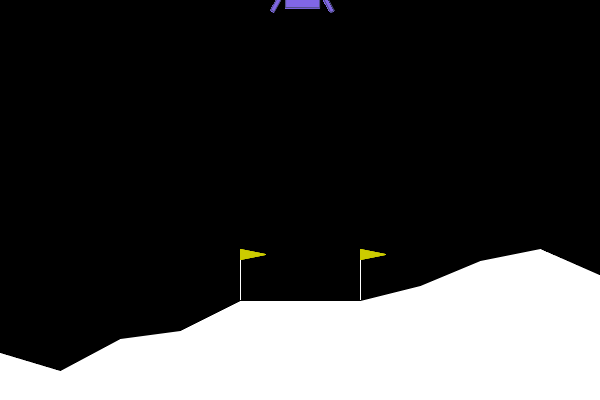

The episode has completed in 100 seconds
| Episode    1 | Duration: 1000 steps | Return: -103.34 | Hovering |


In [53]:
exec_rend(network=online_network, fps=10)

Training the double DQN

You will now modify your code for DQN to implement double DQN.

Double DQN requires only a minimal adjustment to the DQN algorithm, but goes a long way towards solving the Q-value overestimation problem and often performs better than DQN.

In [54]:
total_steps = 0
batch_size = 64
replay_buffer = ReplayBuffer(capacity=10000)

# Run training for n episodes
for episode in range(n_episodes):
    # Reset the environment for a new episode
    # 'state' is the initial observation of the environment
    # 'info' contains optional additional data (e.g., environment details)
    state, info = env.reset()
    
    # Initialize variables for the episode
    done = False  # Flag to indicate the end of the episode
    step = 0  # Counter for the number of steps in the current episode
    episode_reward = 0  # Accumulate the total reward for this episode

    # Continue until the episode is done
    while not done:
        # Increment step counters
        step += 1  # Episode-specific step count
        total_steps += 1  # Global step counter (tracks across episodes)

        # Get the Q-values for the current state from the online network
        # These represent the estimated rewards for each possible action
        q_values = online_network(state)

        # Select an action using the epsilon-greedy strategy
        # Epsilon decays over time (parameters: start=0.9, end=0.05, decay=1000)
        # Balances exploration (random actions) and exploitation (choosing best action)
        action = select_action_greedy(q_values, total_steps, start=.9, end=.05, decay=1000)

        # Perform the selected action in the environment
        # Returns the next state, reward, and whether the episode is terminated or truncated
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Determine if the episode is done
        # It ends if terminated (e.g., success or failure) or truncated (e.g., time limit exceeded)
        done = terminated or truncated

        # Store the experience (state, action, reward, next_state, done) in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Check if the replay buffer has enough samples to perform training
        if len(replay_buffer) >= batch_size:
            # Sample a mini-batch of 64 experiences from the replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Get Q-values for the sampled states using the online network
            # Gather Q-values corresponding to the specific sampled actions
            q_values = online_network(states).gather(1, actions).squeeze(1)

            # Temporarily disable gradient tracking for the target network updates
            with torch.no_grad():
                # Use the online network to select the next actions (action with max Q-value)
                next_actions = online_network(next_states).argmax(1).unsqueeze(1)
                
                # Use the target network to predict the Q-values for the next states
                # Gather Q-values of the selected actions for the next states
                next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
                
                # Compute the target Q-values using the Bellman equation
                # target Q = reward + gamma * max(next Q-value) * (1 - done)
                # (1 - dones) ensures no future reward is added if the episode ends
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

            # Calculate the Mean Squared Error (MSE) loss between predicted and target Q-values
            loss = nn.MSELoss()(q_values, target_q_values)
            
            # Zero the gradients of the optimizer to prepare for backpropagation
            optimizer.zero_grad()
            
            # Perform backpropagation to compute gradients of the loss with respect to network parameters
            loss.backward()
            
            # Update the parameters of the online network using the optimizer
            optimizer.step()

            # Perform a soft update of the target network's parameters to stabilize learning
            # tau controls how fast the target network is updated (e.g., tau=0.005)
            update_target_network(target_network, online_network, tau=.005)

        # Move to the next state
        state = next_state

        # Accumulate the reward obtained at this step into the total episode reward
        episode_reward += reward

    # Once the episode is done, log episode metrics
    # This function outputs information like episode number, total reward, and steps taken
    if episode%descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)


| Episode    1 | Duration:   80 steps | Return: -148.91 | Crashed  |


C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


| Episode   11 | Duration:  204 steps | Return: -28.53  | Crashed  |
| Episode   21 | Duration:  985 steps | Return: -230.59 | Crashed  |
| Episode   31 | Duration: 1000 steps | Return: -78.98  | Hovering |
| Episode   41 | Duration: 1000 steps | Return: -126.68 | Hovering |
| Episode   51 | Duration: 1000 steps | Return: -108.92 | Hovering |
| Episode   61 | Duration: 1000 steps | Return: -125.47 | Hovering |
| Episode   71 | Duration: 1000 steps | Return: -30.43  | Hovering |
| Episode   81 | Duration:  181 steps | Return: 3.50    | Crashed  |
| Episode   91 | Duration: 1000 steps | Return: -58.38  | Hovering |


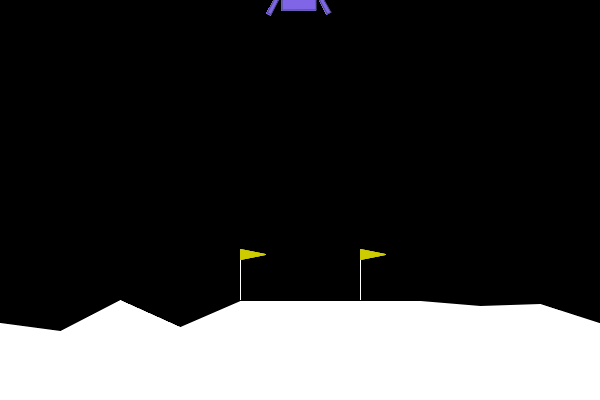

The episode has completed in 100 seconds
| Episode    1 | Duration: 1000 steps | Return: -61.23  | Hovering |


In [55]:
exec_rend(network=online_network, fps=10)

Prioritized experience replay buffer

You will introduce the PrioritizedExperienceReplay class, a data structure that you will later use to implement DQN with Prioritized Experience Replay.

PrioritizedExperienceReplay is a refinement over the ExperienceReplay class that you have been using so far to train your DQN agents. A prioritized experience replay buffer ensures that the transitions sampled from it are more valuable for the agent to learn from than with uniform sampling.

The .sample() method takes as argument the size of the sample you want to draw, and returns the sampled transitions as tensors, along with their indices in the memory buffer and their importance weight.

Priorities and Sampling:

Each transition has a priority, which determines its likelihood of being sampled.

Transitions with higher priorities (e.g., larger TD-errors) are sampled more frequently.

Importance Sampling:

Importance-sampling weights correct for the bias introduced by prioritized sampling.

The weights depend on the sampling probabilities and are scaled using the adjustable beta.

Beta Adjustment:

beta starts at a lower value and increases over time. This gradually compensates for the bias introduced by prioritization.

Epsilon:

A small constant added to priorities ensures all transitions have a non-zero probability of being sampled.

In [56]:
# Define a class for Prioritized Experience Replay Buffer
class PrioritizedReplayBuffer:
    def __init__(
        self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=0.01
    ):
        """
        Initialize the prioritized replay buffer with parameters for prioritization.

        Parameters:
        - capacity: Maximum size of the replay buffer (number of transitions it can store).
        - alpha: Controls how much prioritization is used (0 = no prioritization, 1 = full prioritization).
        - beta: Initial value of beta for importance-sampling weights.
        - beta_increment: The amount by which beta is incremented after each sampling.
        - epsilon: Small constant to ensure non-zero priorities (avoids division by zero).
        """
        # Memory buffer to store experience tuples (state, action, reward, next_state, done)
        self.memory = deque(maxlen=capacity)
        # Store hyperparameters for prioritization and importance sampling
        self.alpha, self.beta, self.beta_increment, self.epsilon = (alpha, beta, beta_increment, epsilon)
        # Priority buffer to store the priorities of transitions
        self.priorities = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Add a new experience to the memory buffer with its corresponding priority.

        Parameters:
        - state: The current state.
        - action: The action taken.
        - reward: The reward received.
        - next_state: The next state after taking the action.
        - done: Boolean flag indicating if the episode ended.
        """
        # Create a tuple to represent the experience
        experience_tuple = (state, action, reward, next_state, done)
        # Assign the maximum priority to the new experience (or 1 if the buffer is empty)
        max_priority = max(self.priorities) if self.memory else 1.0
        # Add the experience and its priority to the respective buffers
        self.memory.append(experience_tuple)
        self.priorities.append(max_priority)
    
    
    def update_priorities(self, indices, td_errors):
        """
        Update the priorities of specific transitions based on their TD-error values.
    
        Parameters:
        - indices: The indices of transitions in the buffer to update.
        - td_errors: The corresponding TD-errors for each transition.
        """
        for idx, td_error in zip(indices, td_errors):
            # Ensure td_error is a float before applying absolute value and epsilon
            if isinstance(td_error, torch.Tensor):
                td_error = td_error.item()  # Extract the value if it's a tensor
            self.priorities[idx] = abs(td_error) + self.epsilon


    def increase_beta(self):
        """
        Increment beta to gradually reduce the effect of prioritization over time.
        - Ensures beta approaches 1.0, where importance sampling fully compensates for bias.
        """
        # Increment beta but clamp it to a maximum of 1.0
        self.beta = min(1.0, self.beta + self.beta_increment)

    def __len__(self):
        """
        Return the current size of the replay buffer.
        """
        return len(self.memory)

    def sample(self, batch_size):
        """
        Sample a batch of experiences from the buffer with prioritized sampling.

        Parameters:
        - batch_size: Number of transitions to sample.

        Returns:
        - Tensors for states, actions, rewards, next_states, dones.
        - Indices of the sampled transitions.
        - Importance-sampling weights for the sampled transitions.
        """
        # Convert the priorities to a numpy array
        priorities = np.array(self.priorities)
        # Compute sampling probabilities using prioritized replay formula
        probabilities = priorities**self.alpha / np.sum(priorities**self.alpha)
        # Randomly sample indices from the memory with the calculated probabilities
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        # Compute the importance weights for the sampled transitions
        weights = (1 / (len(self.memory) * probabilities)) ** self.beta
        # Normalize the weights so the maximum weight is 1
        weights /= np.max(weights)

        # Extract the sampled experiences using the sampled indices
        states, actions, rewards, next_states, dones = zip(*[self.memory[idx] for idx in indices])
        # Extract the corresponding weights for the sampled indices
        weights = [weights[idx] for idx in indices]

        # Convert sampled data into tensors for training
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)
        weights_tensor = torch.tensor(weights, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)  # Ensure proper shape

        # Return the sampled tensors, indices, and importance weights
        return (states_tensor, actions_tensor, rewards_tensor, next_states_tensor,
                dones_tensor, indices, weights_tensor)


In [57]:
# Create the buffer (example usage)
buffer = PrioritizedReplayBuffer(capacity=5)

# Add some experiences to the buffer
buffer.push(state=[1, 1], action=0, reward=1, next_state=[2, 2], done=False)
buffer.push(state=[3, 3], action=1, reward=2, next_state=[4, 4], done=False)
buffer.push(state=[5, 5], action=0, reward=3, next_state=[6, 6], done=True)
buffer.push(state=[7, 7], action=1, reward=4, next_state=[8, 8], done=False)
buffer.push(state=[9, 9], action=0, reward=5, next_state=[10, 10], done=True)

# Print buffer contents and priorities
print("Memory:", list(buffer.memory))
print("Priorities:", list(buffer.priorities))

# Sample a batch of 3 experiences from the buffer
batch = buffer.sample(batch_size=3)

# Display sampled tensors
states, actions, rewards, next_states, dones, indices, weights = batch
print("\nSampled States:\n", states)
print("Sampled Actions:\n", actions)
print("Sampled Rewards:\n", rewards)
print("Sampled Next States:\n", next_states)
print("Sampled Dones:\n", dones)
print("Sampled Indices:\n", indices)
print("Importance Weights:\n", weights)

Memory: [([1, 1], 0, 1, [2, 2], False), ([3, 3], 1, 2, [4, 4], False), ([5, 5], 0, 3, [6, 6], True), ([7, 7], 1, 4, [8, 8], False), ([9, 9], 0, 5, [10, 10], True)]
Priorities: [1.0, 1.0, 1.0, 1.0, 1.0]

Sampled States:
 tensor([[1., 1.],
        [3., 3.],
        [3., 3.]])
Sampled Actions:
 tensor([[0],
        [1],
        [1]])
Sampled Rewards:
 tensor([1., 2., 2.])
Sampled Next States:
 tensor([[2., 2.],
        [4., 4.],
        [4., 4.]])
Sampled Dones:
 tensor([0., 0., 0.])
Sampled Indices:
 [0 1 1]
Importance Weights:
 tensor([1., 1., 1.])


In [ ]:
total_steps = 0
batch_size = 64
replay_buffer = PrioritizedReplayBuffer(10000)

# Loop through n episodes
for episode in range(n_episodes):
    # Reset the environment to start a new episode
    # 'state' is the initial observation, and 'info' may contain additional environment-specific information
    state, info = env.reset()
    
    # Initialize variables for tracking the episode
    done = False  # Flag to track if the episode is finished
    step = 0  # Counter for the number of steps in the episode
    episode_reward = 0  # Accumulates the total reward for the current episode
    
    # Increase the beta parameter of the replay buffer
    # Beta controls the strength of importance sampling weights
    replay_buffer.increase_beta()

    # Continue until the episode is finished
    while not done:
        # Increment the step counters
        step += 1  # Step counter for this episode
        total_steps += 1  # Global step counter across all episodes

        # Get the Q-values for the current state from the online network
        # Q-values represent the expected reward for each possible action in the current state
        q_values = online_network(state)

        # Use epsilon-greedy strategy to select an action
        # This balances exploration (random actions) and exploitation (choosing the best action based on Q-values)
        action = select_action_greedy(q_values, total_steps, start=.9, end=.05, decay=1000)

        # Execute the selected action in the environment
        # Returns the next state, reward, and flags indicating if the episode terminated or was truncated
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Update the done flag based on termination or truncation
        done = terminated or truncated

        # Store the transition (state, action, reward, next_state, done) in the replay buffer
        # The transition is assigned an initial high priority for prioritized sampling
        replay_buffer.push(state, action, reward, next_state, done)

        # If the replay buffer contains at least 'batch_size' transitions, start training
        if len(replay_buffer) >= batch_size:
            # Sample a mini-batch of 64 transitions from the replay buffer
            # Sampling is prioritized based on the TD-errors of previous updates
            states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size)

            # Predict Q-values for the sampled states using the online network
            # Gather Q-values corresponding to the sampled actions
            q_values = online_network(states).gather(1, actions).squeeze(1)

            # Temporarily disable gradient computation for the target network updates
            with torch.no_grad():
                # Predict the maximum Q-values for the next states using the target network
                next_q_values = target_network(next_states).amax(1)

                # Compute the target Q-values using the Bellman equation:
                # target_q_values = rewards + gamma * max(next_q_values) * (1 - dones)
                # (1 - dones) ensures no future reward is added if the episode has ended
                target_q_values = rewards + gamma * next_q_values * (1 - dones)

            # Compute the TD-errors (difference between target and predicted Q-values)
            td_errors = target_q_values - q_values

            # Update the priorities of the sampled transitions in the replay buffer
            # Transitions with larger TD-errors are given higher priorities
            replay_buffer.update_priorities(indices, td_errors)

            # Compute the weighted Mean Squared Error (MSE) loss
            # The weights correct for the bias introduced by prioritized sampling
            loss = torch.sum(weights * (q_values - target_q_values) ** 2)

            # Zero the gradients of the optimizer before backpropagation
            optimizer.zero_grad()

            # Perform backpropagation to compute the gradients of the loss
            loss.backward()

            # Update the parameters of the online network using the optimizer
            optimizer.step()

            # Update the target network's parameters using a soft update mechanism
            # Tau determines the rate of the update (e.g., tau = 0.005)
            update_target_network(target_network, online_network, tau=0.005)

        # Move to the next state for the next iteration
        state = next_state

        # Accumulate the reward received in this step
        episode_reward += reward

    # After the episode ends, log the details of the episode for analysis
    # This function outputs information such as the total reward and steps taken in the episode
    if episode%descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)



C:\Users\Alienware\AppData\Local\Temp\ipykernel_27388\1854855922.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.relu(self.fc1(torch.tensor(state)))


| Episode    1 | Duration: 1000 steps | Return: 58.80   | Hovering |
| Episode   11 | Duration:   76 steps | Return: -228.75 | Crashed  |
| Episode   21 | Duration:  161 steps | Return: -4.41   | Crashed  |
| Episode   31 | Duration:   98 steps | Return: -68.35  | Crashed  |
| Episode   41 | Duration:  334 steps | Return: -79.98  | Crashed  |
| Episode   51 | Duration:  121 steps | Return: -239.88 | Crashed  |


In [ ]:
exec_rend(network=online_network, fps=10)

In [ ]:
# # FULL CODE


# # Define the Q-Network
# class QNetwork(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         return self.fc3(x)

# class PrioritizedReplayBuffer:
#     def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=0.01):
#         self.memory = deque(maxlen=capacity)  # Stores transitions (state, action, reward, next_state, done)
#         self.priorities = deque(maxlen=capacity)  # Stores the priorities for transitions
#         self.alpha = alpha  # Controls prioritization intensity
#         self.beta = beta  # Importance sampling weight parameter
#         self.beta_increment = beta_increment  # Increment for beta
#         self.epsilon = epsilon  # Small value to avoid zero priority

#     def push(self, state, action, reward, next_state, done):
#         max_priority = max(self.priorities) if self.memory else 1.0
#         self.memory.append((state, action, reward, next_state, done))
#         self.priorities.append(max_priority)

#     def sample(self, batch_size):
#         priorities = np.array(self.priorities)
#         probabilities = priorities ** self.alpha / np.sum(priorities ** self.alpha)  # Sampling probabilities
#         indices = np.random.choice(len(self.memory), batch_size, p=probabilities)  # Sample indices
#         weights = (1 / (len(self.memory) * probabilities[indices])) ** self.beta  # Compute importance weights
#         weights /= np.max(weights)  # Normalize weights
#         batch = [self.memory[idx] for idx in indices]  # Gather sampled transitions
#         states, actions, rewards, next_states, dones = zip(*batch)
#         states_tensor = torch.tensor(states, dtype=torch.float32)
#         actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
#         rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
#         next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
#         dones_tensor = torch.tensor(dones, dtype=torch.float32)
#         weights_tensor = torch.tensor(weights, dtype=torch.float32)
#         return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor, indices, weights_tensor

#     def update_priorities(self, indices, td_errors):
#         for idx, td_error in zip(indices, td_errors):
#             self.priorities[idx] = abs(td_error.item()) + self.epsilon

#     def increase_beta(self):
#         self.beta = min(1.0, self.beta + self.beta_increment)  # Gradually increase beta towards 1.0

#     def __len__(self):
#         """
#         Returns the number of transitions currently stored in the buffer.
#         """
#         return len(self.memory)


# # Helper functions
# def select_action(q_values, step, start=1.0, end=0.05, decay=5000):
#     """
#     Selects an action using epsilon-greedy strategy.
#     """
#     epsilon = end + (start - end) * np.exp(-step / decay)  # Compute decayed epsilon
#     if np.random.random() < epsilon:  # Random exploration
#         return np.random.choice(len(q_values))
#     return torch.argmax(q_values).item()  # Exploitation

# def update_target_network(target_network, online_network, tau=0.005):
#     """
#     Soft update of the target network parameters.
#     """
#     for target_param, online_param in zip(target_network.parameters(), online_network.parameters()):
#         target_param.data.copy_(tau * online_param.data + (1 - tau) * target_param.data)

# # Main training function
# def train_lunar_lander():
#     env = gym.make("LunarLander-v3")  # Initialize the environment
#     replay_buffer = PrioritizedReplayBuffer(capacity=10000)  # Initialize prioritized replay buffer
#     input_dim = env.observation_space.shape[0]  # State dimension (8 for LunarLander)
#     output_dim = env.action_space.n  # Action dimension (4 for LunarLander)
#     online_network = QNetwork(input_dim, output_dim)  # Online Q-network
#     target_network = QNetwork(input_dim, output_dim)  # Target Q-network
#     target_network.load_state_dict(online_network.state_dict())  # Initialize target network
#     optimizer = optim.Adam(online_network.parameters(), lr=0.0005)  # Optimizer for online network
#     gamma = 0.99  # Discount factor
#     batch_size = 64  # Mini-batch size
#     total_steps = 0  # Total steps counter

#     # Training loop for episodes
#     for episode in range(n_episodes):
#         state, info = env.reset()  # Reset the environment
#         done = False
#         episode_reward = 0
#         replay_buffer.increase_beta()  # Gradually increase beta
#         while not done:
#             # Get Q-values for current state
#             state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor with batch dim
#             q_values = online_network(state_tensor)
#             action = select_action(q_values, total_steps)  # Select action with epsilon-greedy strategy
#             next_state, reward, terminated, truncated, _ = env.step(action)  # Take action in the environment
#             done = terminated or truncated  # Update done flag
#             replay_buffer.push(state, action, reward, next_state, done)  # Store the transition
#             state = next_state
#             episode_reward += reward
#             total_steps += 1

#             # Perform training step if sufficient data is available in the replay buffer
#             if len(replay_buffer) >= batch_size:
#                 states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size)
#                 q_values = online_network(states).gather(1, actions).squeeze(1)
#                 with torch.no_grad():
#                     next_q_values = target_network(next_states).amax(1)
#                     target_q_values = rewards + gamma * next_q_values * (1 - dones)
#                 td_errors = target_q_values - q_values
#                 replay_buffer.update_priorities(indices, td_errors)  # Update priorities in replay buffer
#                 loss = torch.sum(weights * (q_values - target_q_values) ** 2)  # Compute weighted MSE loss
#                 optimizer.zero_grad()
#                 loss.backward()  # Backpropagate gradients
#                 optimizer.step()  # Update online network parameters
#                 update_target_network(target_network, online_network)  # Update target network

#         print(f"Episode {episode}, Reward: {episode_reward}")  # Print episode progress

#         # Save model periodically
#         if episode % 10 == 0:
#             torch.save(online_network.state_dict(), f"lunar_lander_{episode}.pth")

# # Run the training
# train_lunar_lander()


In [ ]:
# def exec_rend(network, fps):
#     """
#     Executes and renders the environment using the trained network.
    
#     Parameters:
#     - network: The trained neural network for action selection.
#     - fps: Frames per second for rendering and GIF saving.
#     """
#     state, info = env.reset()
#     done = False
#     episode_reward = 0
#     frames = []  # Stores rendered frames
#     steps = 0

#     while not done:
#         # Render the environment and store the frame
#         frame = env.render()
#         frames.append(frame)

#         # Convert state to tensor and pass through the network
#         state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
#         q_values = network(state_tensor)  # Predict Q-values using the trained network
#         action = select_action(q_values, steps)  # Select the action

#         # Execute the action in the environment
#         next_state, reward, terminated, truncated, _ = env.step(action)

#         # Check if the episode has finished
#         done = terminated or truncated

#         # Update state and accumulate reward
#         state = next_state
#         episode_reward += reward
#         steps += 1

#     # Close the rendering window
#     env.close()

#     # Save frames as a GIF
#     gif_path = "lunar_lander.gif"
#     imageio.mimsave(gif_path, frames, fps=fps)

#     # Calculate the GIF duration based on fps
#     gif_duration = math.ceil(steps / fps)

#     # Display the GIF
#     display(Image(filename=gif_path))

#     # Wait for the GIF to finish playing
#     time.sleep(gif_duration)

#     # Print a message after the GIF finishes
#     print("The episode has completed in", gif_duration, "seconds")

#     # Optionally describe the episode (ensure this function is correctly defined elsewhere)
#     describe_episode(0, reward, episode_reward, steps)

# exec_rend(network=online_network, fps=10)

The policy network architecture

Build the architecture for a Policy Network that you can use later to train your policy gradient agent.

The policy network takes the state as input, and outputs a probability in the action space. For the Lunar Lander environment, you work with four discrete actions, so you want your network to output a probability for each of those actions.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        # Give the desired size for the output layer
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(torch.tensor(state)))
        x = torch.relu(self.fc2(x))
        # Obtain the action probabilities
        action_probs = torch.softmax(self.fc3(x), dim=-1)
        return action_probs



In [ ]:
policy_network = PolicyNetwork(8, 4)
policy_network

In [ ]:
optimizer = optim.Adam(policy_network.parameters(), lr=0.0001)

In [ ]:
state = torch.tensor([0.47, 0.55, 0.99, 0.34, 0.94, 0.66, 0.62, 0.83])
state

In [ ]:
action_probs = policy_network(state)
action_probs

Working with discrete distributions

You are soon going to work with stochastic policies: policies which represent the agent's behavior in a given state as a probability distribution over actions.

PyTorch can represent discrete distributions using the torch.distributions.Categorical class, which you will now experiment with.

You will see that it is actually not necessary for the numbers used as input to sum to 1, as probabilities do; they get normalized automatically.

In [ ]:
def sample_from_distribution(probs):
    print(f"\nInput: {probs}")
    probs = torch.tensor(probs, dtype=torch.float32)
    # Instantiate the categorical distribution
    dist = Categorical(probs)
    # Take one sample from the distribution
    sampled_index = dist.sample()
    print(f"Taking one sample: index {sampled_index}, with associated probability {dist.probs[sampled_index]:.2f}")

In [ ]:
# Specify 3 positive numbers summing to 1
sample_from_distribution([.3, .1, .6])

In [ ]:
# Specify 5 positive numbers that do not sum to 1
sample_from_distribution([2, 3, 4, 5, 9])

ction selection in REINFORCE

Write the REINFORCE select_action function, which will be used by your REINFORCE agent to select an action at every step.

In DQN, the forward pass of the network returned Q-values; in REINFORCE, it returns action probabilities, from which an action can directly be sampled.

In [ ]:
def select_action_policy(policy_network, state):
    # Obtain the action probabilities
    action_probs = policy_network(state)
    # print('Action probabilities:', action_probs)
    # Instantiate the action distribution
    action_dist = Categorical(action_probs)
    # print('Action distribution:', action_dist)
    # Sample an action from the distribution
    action = action_dist.sample()
    log_prob = action_dist.log_prob(action)
    return action.item(), log_prob.reshape(1)


In [ ]:
state = torch.rand(8)
action, log_prob = select_action_policy(policy_network, state)
print('Sampled action index:', action)
print(f'Log probability of sampled action: {log_prob.item():.2f}')

Training the REINFORCE algorithm

You are ready to train your Lunar Lander using REINFORCE! All you need is to implement the REINFORCE training loop, including the REINFORCE loss calculation.

Given that the loss calculation steps span across both the inner and outer loops, you will not use a calculate_loss() function this time.

When the episode if complete, you can use both those quantities to calculate the loss.

In [ ]:
# Loop through n episodes
for episode in range(n_episodes):
    # Reset the environment and get the initial state
    state, info = env.reset()
    done = False  # Flag to determine if the episode is finished
    episode_reward = 0  # Total reward for the current episode
    step = 0  # Counter to keep track of the steps in the current episode
    episode_log_probs = torch.tensor([])  # Stores log probabilities of actions taken during the episode
    R = 0  # Cumulative return for the episode (discounted reward)
    
    # Loop until the episode ends
    while not done:
        step += 1  # Increment step count
        
        # Select an action using the policy network and get the log probability of that action
        action, log_prob = select_action_policy(policy_network, state)
        
        # Take the action in the environment and receive the next state, reward, and termination details
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  # Update 'done' if the episode terminates or truncates
        
        episode_reward += reward  # Add the reward from this step to the total episode reward
        
        # Append the log probability of the action to the episode's log probabilities
        episode_log_probs = torch.cat((episode_log_probs, log_prob))
        
        # Calculate the cumulative return (discounted rewards)
        R += (gamma ** step) * reward
        
        # Move to the next state
        state = next_state
    
    # Calculate the loss for this episode
    # The loss is defined as the negative product of the total return and the sum of log probabilities of actions
    loss = -R * episode_log_probs.sum()
    
    # Zero out the gradients to prepare for backpropagation
    optimizer.zero_grad()
    
    # Perform backpropagation to compute gradients of the loss with respect to the policy network's parameters
    loss.backward()
    
    # Update the policy network's parameters using the optimizer
    optimizer.step()
    
    # Log or describe the episode performance (e.g., episode number, final reward, total reward, steps taken)
    if episode % descr_every ==0:
        describe_episode(episode, reward, episode_reward, step)


In [ ]:
exec_rend(network=policy_network, fps=10, PN=True)

Critic network

Actor Critic methods require two very different neural networks.

The architecture for the actor network is identical to that of the policy network you used for REINFORCE, so you can reuse the PolicyNetwork class.

However, the critic network is something you haven't implemented so far. The critic aims to approximate the state value function V(s), rather than the action value function Q(s,a) approximated by Q-Networks.

You will now implement the Critic network module which you will use in A2C.

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        # Fill in the desired dimensions
        self.fc2 = nn.Linear(64, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(torch.tensor(state)))
        # Calculate the output value
        value = self.fc2(x)
        return value

# The critic network you designed takes the state as input, and outputs just one output node, the state value. 
# This value can be used to provide the feedback that will help the actor network learn faster.

In [ ]:
critic_network = Critic(8)
state_value = critic_network(torch.rand(8))
print('State value:', state_value)

Actor Critic loss calculations

As a final step before you can train your agent with A2C, write a calculate_losses() function which returns the losses for both networks.

In [ ]:
def calculate_losses(critic_network, action_log_prob, reward, state, next_state, done):
    # Ensure `state` and `next_state` are PyTorch tensors
    state_tensor = torch.tensor(state, dtype=torch.float32)  # Convert to tensor
    next_state_tensor = torch.tensor(next_state, dtype=torch.float32)  # Convert to tensor

    # Forward pass through the Critic network
    value = critic_network(state_tensor)  # Critic evaluates the current state
    next_value = critic_network(next_state_tensor)  # Critic evaluates the next state

    # Calculate the Temporal Difference (TD) target
    td_target = reward + (1 - done) * gamma * next_value

    # Calculate the TD error
    td_error = td_target - value

    # Actor and Critic losses (example calculation)
    actor_loss = -action_log_prob * td_error.detach()  # Actor loss uses Critic's feedback
    critic_loss = td_error.pow(2)  # Critic minimizes TD error squared

    return actor_loss, critic_loss



In [ ]:
actor_loss, critic_loss = calculate_losses(
        critic_network, log_prob, 
        reward, state, next_state, done
)
print(round(actor_loss.item(), 2), round(critic_loss.item(), 2))

In [ ]:
actor_network = PolicyNetwork(8, 4)
actor_network

In [ ]:
# Assuming `actor_network` and `critic_network` are your neural network models
actor_optimizer = optim.Adam(
    actor_network.parameters(),  # Parameters of the actor network
    lr=0.0001,                   # Learning rate
    betas=(0.9, 0.999),          # Adam's beta parameters
    eps=1e-08,                   # Epsilon for numerical stability
    weight_decay=0,              # Weight decay (L2 penalty)
    amsgrad=False                # Whether to use AMSGrad variant of Adam
)

In [ ]:
# Define the Critic network, adding a extra layer
class Critic_Net(nn.Module):
    def __init__(self, input_size):
        super(Critic_Net, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=64, bias=True)  # First fully connected layer
        self.fc2 = nn.Linear(in_features=64, out_features=64, bias=True)         # Second fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=1, bias=True)         # Output layer

    def forward(self, state):
        x = torch.relu(self.fc1(state))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))     # Apply ReLU activation to the second layer
        x = self.fc3(x)                 # Output the final value without activation
        return x


In [ ]:
critic_network = Critic_Net(8)
critic_network

In [ ]:
critic_optimizer = optim.Adam(
    critic_network.parameters(), # Parameters of the critic network
    lr=0.0001,                   # Learning rate
    betas=(0.9, 0.999),          # Adam's beta parameters
    eps=1e-08,                   # Epsilon for numerical stability
    weight_decay=0,              # Weight decay (L2 penalty)
    amsgrad=False                # Whether to use AMSGrad variant of Adam
)


In [ ]:
# Training the A2C algorithm

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    episode_reward = 0
    step = 0
    while not done:
        step += 1
        if done:
            break
        # Select the action
        action, action_log_prob = select_action_policy(actor_network, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        # Calculate the losses
        actor_loss, critic_loss = calculate_losses(
            critic_network, action_log_prob, 
            reward, state, next_state, done)        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        state = next_state
    if episode % descr_every == 0:
        describe_episode(episode, reward, episode_reward, step)

In [ ]:
exec_rend(network=actor_network, fps=10, PN=True)